# PGM : Homework 3


<ul>
    <li><b>Grégoire BOUSSAC</b></li>
    <li><b>Matthieu TOULEMONT</b></li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from scipy.special import logsumexp
apply = lambda func,x: list(map(func, x))

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
df = pd.read_csv('EMGaussian.data', header = None, sep =' ')
df.columns = ['x1', 'x2']

## Parameters and results  from HW2

In [3]:
mus = np.array([[-3.06223209, -3.53483292],
       [ 3.97883932,  3.80468785],
       [ 3.80061717, -3.7871236 ],
       [-2.0344612 ,  4.1723392 ]])

Sigmas = np.array([[[ 6.24015854,  6.04881613],
        [ 6.04881613,  6.18098611]],

       [[ 0.20988856,  0.28538583],
        [ 0.28538583, 12.09461933]],

       [[ 0.91670776,  0.05738383],
        [ 0.05738383,  1.88742695]],

       [[ 2.90383723,  0.20557035],
        [ 0.20557035,  2.75602882]]])

def loglikelihood(df, PIs, mus, sigmas, m_weights, K = 4):
    l1 = np.sum(m_weights*np.log(np.repeat(PIs.reshape(1,4), df.shape[0], axis = 0)))
    l2 = -1*np.sum(list((\
                         m_weights[i,k]*(\
                                         np.log(2*np.pi)+ 0.5*np.log(np.linalg.det(Sigmas[k,:])) \
                    + 0.5*(df.values[i,:] -mus[k,:]).T.dot(np.linalg.inv(Sigmas[k,:])).dot(df.values[i,:]-mus[k,:]) ))\
                        for i in range(df.shape[0]) for k in range(K) ) )
    return l1+l2

In [4]:
pdf = lambda x,mu, Sigma: 1/(2*np.pi*np.power(np.linalg.det(Sigma),0.5))*np.exp(-0.5*(x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu))

weigths = lambda x,mu,Sigma, PI: PI*pdf(x,mu,Sigma)

def EM_hw2(df, mus, Sigmas, Niter, K = 4):
    Closest = np.argmin(np.hstack((np.linalg.norm(df.values - mus[i,:], axis = 1).reshape(-1,1) for i in range(4))), axis = 1)
    PIs = np.array(list((Closest == i).sum() for i in range(K)))/df.shape[0]
    LogC = np.zeros(Niter)
    for Iter in range(Niter):
        # E step : Compute membership weights:
        m_weights = np.vstack(list(np.array(list(weigths(df.values[i,:], mus[k], Sigmas[k], PIs[k]) for k in range(K))).reshape(1,-1) for i in range(df.shape[0])))
        m_weights /= np.repeat(m_weights.sum(axis = 1, keepdims=True),4,axis = 1)

        # M Step : Update parameters
        N = np.sum(m_weights, axis = 0)
        PIs = N/df.shape[0]
        mus = np.vstack(list(((np.repeat(m_weights[:,k].reshape(-1,1), 2, axis = 1)*df.values).sum(axis = 0)/N[k]).reshape(1,-1) for k in range(K)))
        Sigmas = np.vstack(list((((np.repeat(m_weights[:,k].reshape(-1,1), 2, axis = 1)*(df.values - mus[k,:])).T.dot(df.values - mus[k,:])/N[k]).reshape(1,2,2) for k in range(K))))
        LogC[Iter] = loglikelihood(df, PIs, mus, Sigmas, m_weights)

    # Last E step : Compute membership weights:
    m_weights = np.vstack(list(np.array(list(weigths(df.values[i,:], mus[k], Sigmas[k], PIs[k]) for k in range(K))).reshape(1,-1) for i in range(df.shape[0])))
    m_weights /= np.repeat(m_weights.sum(axis = 1, keepdims=True),4,axis = 1)  
    return mus, Sigmas, m_weights, LogC

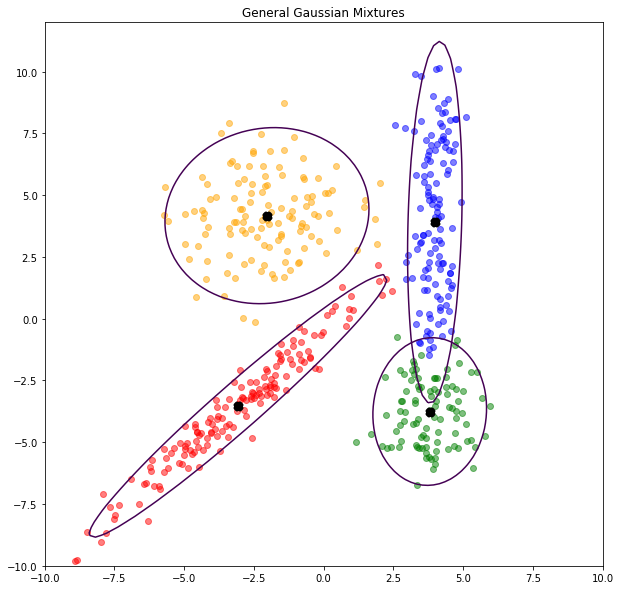

In [5]:
mus, Sigmas, m_weights, LogC = EM_hw2(df, mus, Sigmas, 1, K = 4)
mu = mus
Sigma = Sigmas

N = 100
x = np.linspace(-10,10,N)
y = np.linspace(-10,12,N)
x, y = np.meshgrid(x,y)
Z = np.zeros((4,N,N))
for i in range(100):
    for j in range(100):
        X = np.array([x[i,j], y[i,j]])
        for k in range(4):
            Z[k,i,j] = (X - mu[k,:]).T.dot(np.linalg.inv(Sigma[k,:,:])).dot((X - mu[k,:]))
            

Closest = np.argmax(m_weights, axis = 1)
cols = ['red', 'blue', 'green', 'orange']
plt.figure(figsize = (10,10))
for i in range(4):
    plt.scatter(df.loc[np.where(Closest == i)]['x1'], df.loc[np.where(Closest == i)]['x2'], c=cols[i], alpha=0.5)
    plt.scatter(mus[i,0], mus[i,1], c='black', marker = "X",linewidths=4)
    plt.contour(x,y,Z[i], [-2*np.log(0.1)])
plt.title('General Gaussian Mixtures')
plt.savefig('EM_GMM.eps')
plt.show()

## Hidden Markov Model

In [64]:
class HMM:
    """
    Hidden Markov Model with Gaussian Mixture Model.
    
    @uthor : Matthieu Toulemont and Grégoire Boussac.
    
    
    Notations : 
        - K number of hidden states
        - (y_t) are the observations
        - (z_t) are the hidden states taking values in {1.. K}
        - For all t, for all k : y_t | (z_t = k) ~ N(mu_k, Sigma_k)
        
    """
    def __init__(self, mu,sigma,eps, K = 4, dim = 2, datafile = 'EMGaussian.data'):
        self._df = None
        self._K = None 
        self._T = None
        self._dim = None
        self._eps = None
        self._mu = None     
        self._sigma = None     
        self._log_A = None
        self._log_pi = None
        self._log_gamma = None
        self._log_gamma = None
        self._gamma = None
        self._log_gamma = None
        
        self.initialize(datafile, mu, sigma,eps, K, dim)
        
    @property
    def df(self):
        return self._df
    
    @df.setter
    def df(self, value):
        self._df = value
        
    @property
    def K(self):
        return self._K
    
    @K.setter
    def K(self, value):
        self._K = value
    
    @property
    def T(self):
        return self._T
    
    @T.setter
    def T(self, value):
        self._T = value
    
    @property
    def dim(self):
        return self._dim
    
    @dim.setter
    def dim(self, value):
        self._dim = value
    
    @property
    def eps(self):
        return self._eps
    
    @eps.setter
    def eps(self, value):
        self._eps = value
    
    @property
    def mu(self):
        return self._mu
    
    @mu.setter
    def mu(self, value):
        self._mu = value
    
    @property
    def sigma(self):
        return self._sigma
    
    @sigma.setter
    def sigma(self, value):
        self._sigma = value
    
    @property
    def log_A (self):
        return self._log_A 
    
    @log_A.setter
    def log_A(self, value):
        self._log_A = value
    
    @property
    def log_pi(self):
        return self._log_pi
    
    @log_pi.setter
    def log_pi(self, value):
        self._log_pi = value
    
    @property
    def log_alpha(self):
        return self._log_alpha
    
    @log_alpha.setter
    def log_alpha(self, value):
        self._log_alpha = value
    
    @property
    def log_beta(self):
        return self._log_beta
    
    @log_beta.setter
    def log_beta(self, value):
        self._log_beta = value
    
    @property
    def log_gamma(self):
        return self._log_gamma
    
    @log_gamma.setter
    def log_gamma(self, value):
        self._log_gamma = value
    
    @property
    def gamma(self):
        return self._gamma
    
    @gamma.setter
    def gamma(self, value):
        self._gamma = value
    
    @property
    def log_ksi(self):
        return self._log_ksi
    
    @log_ksi.setter
    def log_ksi(self, value):
        self._log_ksi = value
    
    def initialize(self, datafile, mu, sigma,eps, K, dim):
        self.df = pd.read_csv(datafile, header = None, sep =' ')
        self.df.columns = ['x1', 'x2']
        self.K = K
        self.dim = dim
        self.T = self.df.shape[0]
        self.eps = eps
        
        self.log_pi = np.log(1 / self.K * np.ones(self.K))
        self.log_A = np.log(1 / 6 * np.ones((self.K, self.K)) + 1 / 3 * np.eye(self.K))
        self.mu = mu
        self.sigma = sigma
        self.gamma = np.zeros((self.K, self.T))
        self.log_gamma = np.zeros((self.K, self.T))
        self.log_alpha = np.zeros((self.K, self.T))
        self.log_beta = np.zeros((self.K, self.T))
        self.log_ksi = np.zeros((self.T, self.K, self.K))
        
        # First pass
        l = self._current_logpdf()
        self._alpha_log_recursion(l)
        self._beta_log_recursion(l)
        self._compute_log_gamma()
        self._compute_log_ksi(l)
    
    def _current_logpdf(self, df = None):
        """
        Computes the 'log-density function' for each state for each observation.
        """
        if df is None:
            df = self.df
        loglikelihood = np.log(np.vstack((scs.multivariate_normal.pdf(x = df.values, mean = self.mu[k], cov = self.sigma[k]).reshape(1,-1) for k in range(self.K))))
        return loglikelihood
    
    def _alpha_log_recursion(self, logpdf, mode="train"):
        """
        Forward pass
        """
        K,T = logpdf.shape
        log_alpha = np.zeros((self.K, self.T))
        log_alpha[:,0] = self.log_pi+logpdf[:,0]
        for t in range(1,T):
            for k in range(K):
                log_alpha[k,t] = logpdf[k,t]+logsumexp(self.log_A[k,:] + log_alpha[:,t-1])
        if mode == "train":
            self.log_alpha = log_alpha
        elif mode =="test":
            return log_alpha
    
    def _beta_log_recursion(self, logpdf, mode = "train"):
        """
        Backward Pass
        """
        K,T = logpdf.shape
        log_beta = np.zeros((K, T))
        log_beta[:,T-1] = np.log(np.ones(K))
        for t in range(T-2,-1,-1):
            for k in range(K):
                log_beta[k,t] = logsumexp(self.log_A[:,k] + logpdf[:,t+1] + log_beta[:,t+1])
        if mode == "train":
            self.log_beta = log_beta
        elif mode == "test":
            return log_beta
    
    def _compute_log_gamma(self, mode="train", log_alpha=None,log_beta=None):
        """
        Computes log(p(z_t|y_0, .. , y_T))
        """
        if (log_alpha is None) and (log_beta is None):
            log_alpha, log_beta = self.log_alpha, self.log_beta
        K = log_alpha.shape[0]
        log_gamma = log_alpha + log_beta
        log_gamma -= np.repeat(logsumexp(log_alpha+ log_beta, axis = 0).reshape(1,-1), K, axis = 0)
        if mode == "train":
            self.log_gamma = log_gamma
        elif mode == "test":
            return log_gamma
    
    def _compute_log_ksi(self, logpdf, mode = "train",log_alpha = None, log_beta = None):
        """
        Computes log(p(z_t+1, z_t |y_0, .. , y_T ))
        """
        K,T = logpdf.shape
        log_ksi = np.zeros((T-1, K, K))
        
        if (log_alpha is None) and (log_beta is None):
            log_alpha, log_beta = self.log_alpha, self.log_beta
        for t in range(T-1): 
            log_p_obs = logsumexp(log_alpha[:,t]+ log_beta[:,t])
            for k in range(K):
                for kp1 in range(K):
                    log_ksi[t,k,kp1] = log_alpha[k,t]+log_beta[kp1, t+1]+self.log_A[kp1,k] + logpdf[kp1, t+1] - log_p_obs
        if mode == "train":
            self.log_ksi = log_ksi
        elif mode == "test":
            return log_ksi
    
    def _compute_loglikelihood(self,logpdf,log_gamma=None, log_ksi = None):
        K,T = logpdf.shape
        if (log_gamma is None) and (log_ksi is None):
            log_gamma, log_ksi = self.log_gamma, self.log_ksi
        gamma = np.exp(log_gamma)
        ksi = np.exp(log_ksi)
        l1 = np.sum(gamma[:,0]*log_gamma[:,0])
        l2 = 0
        for t in range(T-1):
            l2 += np.sum(ksi[t,:,:]*self.log_A)
        l3 = np.sum(logpdf*gamma)
        return (l1 + l2 + l3)*1./T
        
    def _E_log_step(self):
        """
        Expectation step of the EM algorithm.
        """
        logpdf = self._current_logpdf()
        self._alpha_log_recursion(logpdf)
        self._beta_log_recursion(logpdf)
        self._compute_log_gamma()
        self._compute_log_ksi(logpdf)
    
    def _M_step(self):
        """
        Maximization step of the EM algorithm.
        """
        self.log_pi = self.log_gamma[:,0]
        self.log_A = logsumexp(self.log_ksi, axis = 0) - np.log(np.sum(np.sum(np.exp(self.log_ksi), axis = 0), axis = 0))

        self.gamma = np.exp(self.log_gamma)
        self.mu = np.vstack(((np.sum(np.repeat((self.gamma[k,:].reshape(-1,1)), 2, axis = 1)*df[['x1', 'x2']].values[:self.T,:], axis = 0)/(np.sum(self.gamma[k,:]))).reshape(1, self.dim)) for k in range(self.K))
        self.sigma = np.vstack(list((((np.repeat(self.gamma[k,:].reshape(-1,1), 2, axis = 1)*(self.df[['x1', 'x2']].values[:self.T,:] - self.mu[k,:])).T.dot(self.df[['x1', 'x2']].values[:self.T,:] - self.mu[k,:])/(np.sum(self.gamma[k,:]))).reshape(1,2,2) for k in range(self.K))))
    
    def EM(self):
        """
        EM algorithm.
        """
        gamma_old = self.gamma.copy() +1
        c = 0
        while np.linalg.norm(gamma_old - self.gamma) > self.eps:
            print(str(c) + "   : {}".format(np.round(np.linalg.norm(gamma_old - self.gamma), 3)))
            gamma_old = self.gamma.copy()
            self._E_log_step()
            self._M_step()
            c+=1
        print("Done")
    
    def Eval(self, df):
        logpdf = self._current_logpdf(df = df[['x1', 'x2']])
        log_alpha = self._alpha_log_recursion(logpdf = logpdf, mode="test")
        log_beta = self._beta_log_recursion(logpdf = logpdf, mode="test")
        log_gamma = self._compute_log_gamma(mode="test",log_alpha=log_alpha, log_beta=log_beta)
        log_ksi = self._compute_log_ksi(logpdf, mode="test",log_alpha=log_alpha, log_beta=log_beta)
        
        df['cluster'] = np.argmax(log_gamma, axis = 0).flatten()
        loglikelihood = self._compute_loglikelihood(logpdf, log_gamma = log_gamma, log_ksi = log_ksi)
        print(loglikelihood)
    
    def plot_proba(self):
        """
        Show p(z_t|y_0, .. , y_T) for each observation.
        """
        plt.figure(figsize = (15,10))
        for k in range(self.K):
            plt.plot(np.arange(self.T), self.gamma[k,:], label = 'P cluster '+str(k))
        plt.legend()
        plt.show()
    def plot_hidden_states(self, df = None):
        N = 100
        x = np.linspace(-10,10,N)
        y = np.linspace(-10,12,N)
        x, y = np.meshgrid(x,y)
        Z = np.zeros((4,N,N))
        for i in range(100):
            for j in range(100):
                X = np.array([x[i,j], y[i,j]])
                for k in range(4):
                    Z[k,i,j] = (X - self.mu[k,:]).T.dot(np.linalg.inv(self.sigma[k,:,:])).dot((X - self.mu[k,:]))
        cols = ['red', 'blue', 'green', 'orange']
        plt.figure(figsize = (10,10))
        if df is None:
            df = self.df
            Closest = np.argmax(self.gamma, axis = 0)
            df['cluster'] = Closest.flatten()
            title="Training Data"
        else:
            self.Eval(df=df)
            title="Test Data"
        for i in range(4):
            plt.scatter(df[df['cluster']==i]['x1'], df[df['cluster']==i]['x2'], c=cols[i], alpha=0.5)
            plt.scatter(self.mu[i,0], self.mu[i,1], c='black', marker = "X",linewidths=4)
            plt.contour(x,y,Z[i], [-2*np.log(0.1)])
        plt.title(title+' Hidden states' )
        plt.savefig('HMM_{}.eps'.format(title.split(' ')[0]))
        plt.show()
    def plot_results(self):
        self.plot_proba()
        self.plot_hidden_states()

In [65]:
hmm = HMM(mus, Sigmas, 0.001)
hmm.EM()
hmm.p

0   : 44.721
1   : 21.977
2   : 3.827
3   : 1.21
4   : 0.496
5   : 0.21
6   : 0.086
7   : 0.035
8   : 0.014
9   : 0.006
10   : 0.002
Done


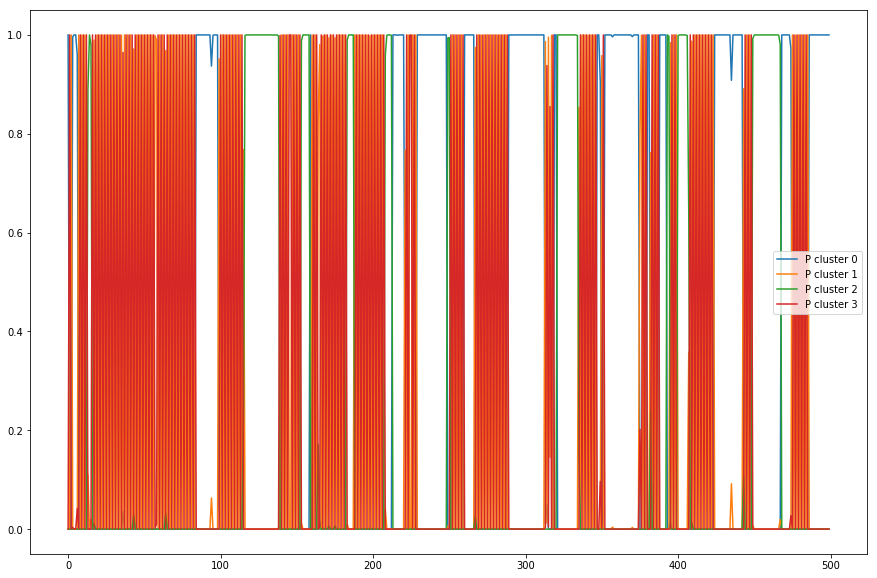

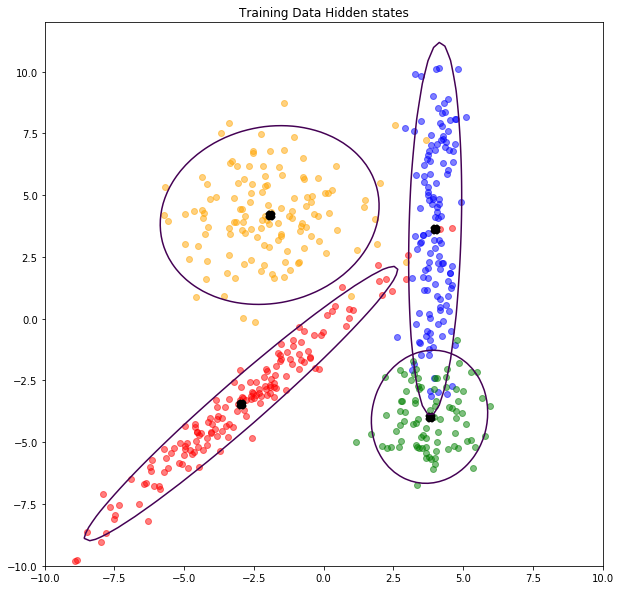

-3.917400384989172


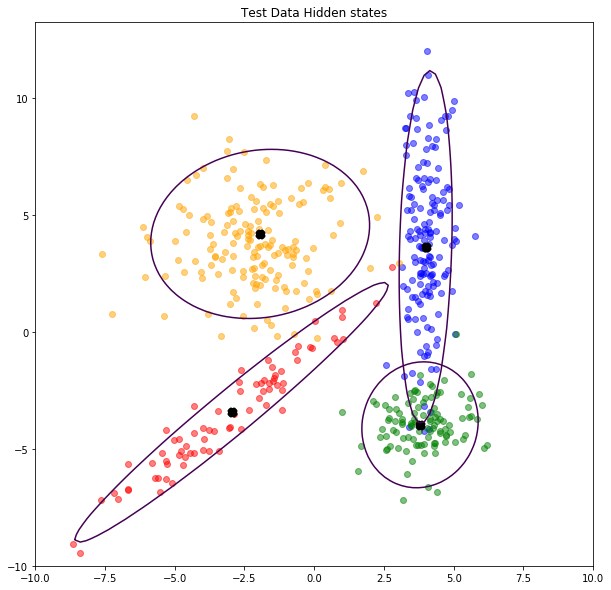

In [70]:
dtest = pd.read_csv('EMGaussian.test', header = None, sep =' ')
dtest.columns = ['x1', 'x2']
hmm.plot_proba()
hmm.plot_hidden_states()
hmm.plot_hidden_states(df = dtest)